<a href="https://colab.research.google.com/github/NinelK/IMBIZO2022_DS_tutorial_solutions/blob/main/DS_Tutorial_Parts_1_2_SOLUTIONS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Tutorial:** Dynamical systems in neuroscience

## Introduction

Dynamical systems are systems that **evolve** in time. These can be physical systems, economic systems, neurons, neural networks or the whole brain. No matter what the system is, the universal dynamical system framework can help us understand its time-dependent behavior.

When modelling dynamics, we can represent time in two different ways: *discrete* or *continuous*. In both cases, we can write down the evolution of the system as a function of its previous `state' $\mathbf{x}$ and external inputs that the system receives $\mathbf{u}$:

Discrete time systems               |           Continuous time systems
------------------------------------|-------------------------------------
 $\mathbf{x}_{t+1} = F_d(\mathbf{x}_t,\mathbf{u}_t)$           |    $\frac{d\mathbf{x}(t)}{dt} = F_c(\mathbf{x}(t),\mathbf{u}(t))$
 
*Notation:* The variables in **bold** here correspond to vectors, e.g. $\mathbf{x} = (x_1,x_2,\ldots,x_n)^T$.

Here, the state $\mathbf{x}$ can, for instance, correspont to neural firing. In discrete case, $\mathbf{x}_t$ would be the number of spikes emmited within one time bin, while $\mathbf{x}(t)$ could be a function which is only non-zero at spike times.
External inputs $\mathbf{u}$ in this case would correspond to the inputs from other neurons.

The key part of the dynamical systems framework is the **evolution function** $F$. Whether continuous $F_c$ or discrete $F_d$, it can tell us a lot about the system:
> The power of the dynamical systems approach to neuroscience, as well as to many other sciences, is that we can tell something, or many things, about a system without knowing all the details that govern the system evolution. We do not even use equations to do that! Some may even wonder why we call it a mathematical theory.        *Eugene Izhikevich [1]*

Therefore, the main goal of the tutorial is to learn how to tell something about the dynamical system knowing $F$.

## Setups

In [161]:
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets       # interactive display
from matplotlib import rcParams
from scipy.linalg import expm
from scipy.optimize import minimize
from matplotlib import cm
cmap = cm.get_cmap("RdYlGn")
rcParams.update({'font.size': 18})
import warnings
warnings.filterwarnings("ignore")

# Part 1: Autonomous linear dynamical systems (LDS)

Sometimes, we can assume that the system does not receive any external inputs and evolves in time on its own ( $u(t)=0$ ). Such dynamical systems are called **autonomous**. Autonomous systems are common in physics, but also surprisingly applicable to some biological neural networks, as we will see in the last part of the tutorial. Lack of external inputs greatly simplifies the analysis of the dynamics $F$, so let us assume **no** external inputs for now.

As a warmup, let us start with a 1D autonomous continuous-time dynamical system:

$$\frac{dx}{dt} = \dot x = a x; \qquad x(0) = x_0 \tag{1} $$

We are looking at a so-called *initial value problem* here: we know the state of the system $x_0$ at $t=0$, but we want to make a forecast into the future and find $x(t)$ for $t>0$.

## Solving a 1D linear dynamics equation
Let us solve equation (1) both numerically and analytically.

For analytical solution, let us reorder the variables and integrate both sides of the equation just on paper:

$$\int_{x_0}^{x_t} \frac{dx}{x} = \int_{0}^t a dt \tag{2a}$$

For numerical integration, we will use the *forward Euler* scheme:

$$\frac{dx}{dt} \approx \frac{\Delta x}{\Delta t} = \frac{x_{n+1} - x_n}{\Delta t} \tag{2b}$$

We can then write down an analytical solution at any time point $t$ based on (2a), and also get a numerical approximation of the same integral by applying the update rule $x_{n+1} \rightarrow x_n$ based on (2b) in a for-loop:

### **Exercise 1:** Analytical vs numerical solutions
Complete the missing lines in the code below. Does analytical solution match the numerical solution? 

In [162]:
def analytical_1D_solution(x0,a,t):
  ''' Finds a solution of x' = ax, for x(t), given x(0) = x0 '''
  xt = x0 * np.exp(a*t) # 2remove
  return xt

def numerical_1D_solution(x0,a,t,dt=0.001):
  ''' Integrates x' = ax using a forward Euler scheme, given x(0) = x0;
  Returns x(t) '''
  N = int(t//dt) # number of integration steps #2remove
  xn = x0 # current value of x_n
  for n in range(N):
    x_n_plus_1 = xn + a*xn*dt #2remove write a discretized update rule following (1-2) #2remove
    xn = x_n_plus_1  
  return xn

In [163]:
T = 2 # total duration
n_plot = 10 # how many points to plot

@widgets.interact
def plot_1D_solutions(x0 = 1., 
                      a = widgets.FloatSlider(min=-2., max=2., step=1, value=1),
                      dt = widgets.FloatLogSlider(min=-3, max=-1, value=.01)):
  a = a if type(a)==float else a.value
  dt = dt if type(dt)==float else dt.value
  plt.figure()
  time = np.linspace(0,T,n_plot)
  plt.plot(time, [analytical_1D_solution(x0,a,t) for t in time],label='Analytical solution')
  plt.plot(time, [numerical_1D_solution(x0,a,t,dt) for t in time],label='Numerical solution')
  plt.xlim([0,T])
  plt.ylim([-5,5])
  plt.axhline(0,c='k',linestyle=':')
  plt.xlabel('time')
  plt.ylabel('state x')
  plt.legend()

interactive(children=(FloatSlider(value=1.0, description='x0', max=3.0, min=-1.0), FloatSlider(value=1.0, desc…

#### **Think!**
When do the solutions agree? Disagree? Why?


**Answer:** analytical and computational solutions are in agreement if the integration step $dt$ is sufficiently small. If it is large, then forward Euler scheme turns into a poor approximation of the derivative.

#### **Think!**

How many qualitatively different solutions have you found? What are they?


**Answer:** there are 3 qualitatively different solutions: a 1-dimensional LDS can either converge to zero ($a<0$), stay constant ($a=0$) or exponentially explode ($a>0$).

### **Take home message**

$a$ determines how the amplitude of the solution changes (decays, amplifies or stays constant)
<!-- In a 1D linear autonomous dynamical system with a single parameter $a$:
1. Real part of $a$ determines how the amplitude of the solution changes (decays, amplifies or stays constant)
2. Imaginary part of $a$ determines the frequency of oscillations -->

## Auxilary variables and phase portraits

In Exercise 1 we have observed a 1D system can exponentially grow, decay, or stay the same. But we know that many systems in neuroscience do neither. They often oscillate!

To get started with oscillations, let us consider another simple system that oscillates: a pendulum!

<img src='https://upload.wikimedia.org/wikipedia/commons/thumb/8/83/Mathematical_pendulum.svg/950px-Mathematical_pendulum.svg.png' width=200px align='right'>

The dynamics of the pendulum can be derived from first principles (Newton's laws of mechanics):

$$\ddot \theta = - g \sin(\theta) \approx -g \theta$$

which turns into a linear system if the oscillations are small ($\theta \ll 1$). We can further simplify the system by assuming $g=1$.

This equation, however, contains a higher order derivative ($\ddot \theta$). How can we get rid of it?

We can introduce an additional auxilary variable $\omega = \dot \theta$, then:
$$\ddot \theta = \dot \omega = -\theta$$

Now we have two equations that resemble (1), which we can combine into a single vector-valued equation for a state $\mathbf{x} = [~\theta,~\omega~]^T$:

$${\begin{bmatrix}
    \dot \theta \\
    \dot \omega
\end{bmatrix}} = \begin{bmatrix}
    0 & 1 \\
    -1 & 0
\end{bmatrix} \begin{bmatrix}
    \theta \\
    \omega
\end{bmatrix} $$

or simply:

$$\mathbf{\dot x} = A \mathbf{x} \tag{3}$$

Looks similar to the 1D system in (1). Then how does it cause oscillations? 🤔 Let's find out.

## Solving a 2D linear dynamics equation

### **Exercise 2:** Solve 2D linear dynamics equation of a pendulum numerically

Fill in the missing line of code below to numerically integrate the eq. (3).

*Hint: for matrix multiplication in python you can use @ sign*

*Note:* the analytical solution of eq. (3) is given to you in the code. It involves matrix exponential. If you don't know what it is -- no worries, it is not important for this tutorial.

In [164]:
def analytical_2D_solution(x0,A,t):
  ''' Finds a solution of x' = Ax, for x(t), given x(0) = x0 '''
  xt = expm(A*t) @ x0 # this solution includes matrix exponential (https://en.wikipedia.org/wiki/Matrix_exponential)
  return xt

def numerical_2D_solution(x0,A,t,dt=0.01):
  ''' Integrates x' = Ax using a forward Euler scheme, given x(0) = x0;
  Returns x(t) '''
  N = int(t//dt) # number of integration steps #2remove
  xn = x0 # current value of x_n
  for n in range(N):
    x_n_plus_1 = xn + (A @ xn)*dt # write a discretized update rule following (1-2) #2remove
    xn = x_n_plus_1  
  return xn

T = 10 # total duration
n_plot = 100 # how many points to plot

A = np.array([[0, 1], 
              [-1, 0]]) # pendulum dynamics

In [165]:
@widgets.interact
def plot_2D_solutions(phi0 = (-1,1,0.1),
                      omega0 = (-1,1,0.1)):
  x0 = np.array([phi0, omega0])
  fig, axes = plt.subplots(1,3,figsize=(12,2),gridspec_kw={'width_ratios': [2, 1, 2]})
  time = np.linspace(0,T,n_plot)
  analytical_traj = np.array([analytical_2D_solution(x0,A,t) for t in time])
  numerical_traj = np.array([numerical_2D_solution(x0,A,t) for t in time])
  
  axes[1].plot(*numerical_traj.T,c='k')
  axes[1].plot(*analytical_traj.T,c='C1',linestyle=':')
  axes[1].set_xlabel(r"$\theta$")
  axes[1].set_ylabel(r"$\omega = \dot\theta$")
  axes[1].set_xlim([-1.2,1.2])
  for ax in axes:
    ax.set_ylim([-1.2,1.2])

  axes[0].plot(numerical_traj[:,0],c='k')
  axes[0].plot(analytical_traj[:,0],c='C1',linestyle=':')
  axes[0].set_xlabel(r"time")
  axes[0].set_ylabel(r"$\theta$")

  axes[2].plot(numerical_traj[:,1],c='k',label='Numerical solution')
  axes[2].plot(analytical_traj[:,1],c='C1',linestyle=':',label='Analytical solution')
  axes[2].set_xlabel(r"time")
  axes[2].set_ylabel(r"$\omega = \dot\theta$")
  axes[2].legend(loc=(1.2,0))

  plt.subplots_adjust(left=None, bottom=.2, right=None, top=None, wspace=0.4, hspace=0.)

interactive(children=(FloatSlider(value=0.0, description='phi0', max=1.0, min=-1.0), FloatSlider(value=0.0, de…

The plot in the middle is called a *phase portrait* in mechanics: you can see why if you change the angular velocity $\omega$ and see how left/right plots change. This portrait exists in a *phase space* $[\theta, \omega]$.

In physics, we can derive the dynamics equations from first principles, so we know that these two variables: position $\theta$ and angular velocity $\omega$, fully describe the **state** of the pendulum. Knowing the state, we know what happens next, because the system is **deterministic** (no noise in eq. (1) or (3)).
Therefore, in a more general context, a minimal set of variables that describe the state of the system form a **state space**. 

<!-- However, in a more general context, the components of $x$ that describe the dynamics of the system can be anything! For instance, $x_1, x_2, \ldots, x_n$ can correspond to activities of neurons in a neural network.    -->


## From particular to general: visualizing dynamics with phase portraits

We have learned that if we know the state of the the system at any time point $t_0$, we can predict what happes next. We already integrated the dynamics eq. (3) given certain initial conditions and visualized some trajectories for a pendulum. But can we summarize and visualize all the possible states and transitions between them?

### **Exercise 3:**  visualize the equation (3) using stream plots. 
For every state, equation (3) defines the derivative (i.e. where the system goes next), which we can visualize with arrows:

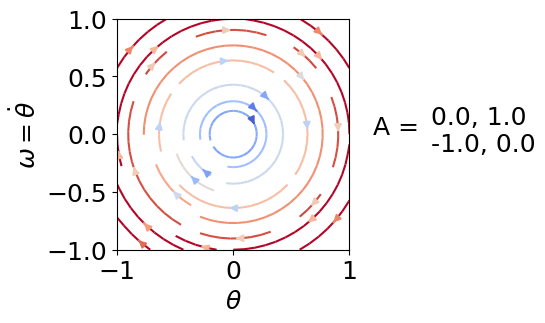

In [166]:
# Plotting phase portraits
def plot_phase_portrait(A,n = 10, xlabel=r'$x_1$', ylabel=r'$x_2$', Alabel='A'):
  '''
    A: matrix 2x2
    n: number of points in the n x n grid
  '''
  plt.figure(figsize=(3,3))
  x1 = np.linspace(-1, 1, n) # a 1D grid
  x = np.array(np.meshgrid(x1, x1)).reshape((2,-1)) # a 2D flattened grid
  # calculate the time-derivative of the state x in the line below
  # the output shape should be [2 x n^2]
  x_dot = A @ x # 2remove
  x_dot = x_dot.reshape((2,n,n))
  plt.streamplot(x1,x1,*x_dot,color=np.linalg.norm(x_dot,axis=0),cmap='coolwarm',density=0.5)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel);
  plt.text(1.2,0,f'{Alabel} = ')
  plt.text(1.7,-.15,f'{A[0,0]:.1f}, {A[0,1]:.1f} \n{A[1,0]:.1f}, {A[1,1]:.1f}')
  plt.xlim([-1,1])
  plt.ylim([-1,1])
  plt.clim(vmin=0,vmax=1)

A = np.array([[0, 1], 
              [-1, 0]]) # pendulum dynamics
plot_phase_portrait(A, xlabel=r'$\theta$', ylabel=r'$\omega = \dot\theta$')

Following these streamlines in a figure above from some initial point $x_0$ step-by-step corresponds to integrating $\int_{t_0}^{t} \dot x(t) dt$ that we did in the previous exercise!

Color here shows how fast the state evolves: cooler colors mean slower, warmer colors -- faster!
(darkest blue: $|\mathbf{\dot x}| = 0$, brightest red: $|\mathbf{\dot x}| = 1$)

Like in Izhekevich quote, we don't even need to write equation to tell how the system behaves 🤯

## Analysing two-dimensional linear dynamics

### Change of basis
The pendulum example above is, perhaps, the simplest linear dynamical system in physics. Its phase portrait is symmetrical!

But for other dynamical systems, with other matrices $A$, this might not be the case:

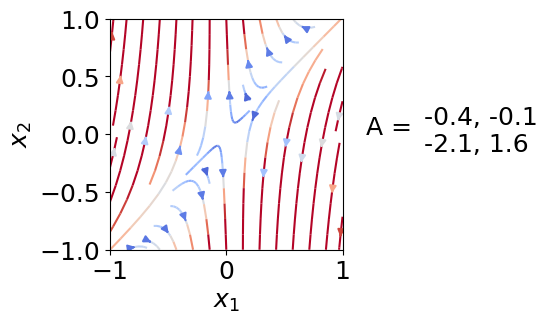

In [167]:
np.random.seed(2)
A = np.random.randn(2,2) # pick some values from N(0,1) for each component

plot_phase_portrait(A)


Looks very complicated! All elements in $A$ are non-zero, so each derivative $\dot x_i$ depends on both $x_1$ and $x_1$. Can we make it better? Can we somehow split a 2D system into a combination of two 1D systems?

We are now considering an abstract linear dynamical system, so the components $x_1$ and $x_2$ do not mean much... Can we stretch and rotate this space such that in these new coordinates $(\hat x_1, \hat x_2)$  the derivatives $d{\hat x_i}/dt$ only depend on the respective component $x_i$ ? Or, in other words, can we change the basis to make the matrix $A$ diagonal?

$$\begin{bmatrix}
\frac{d\hat x_1}{dt} \\
\frac{d\hat x_2}{dt}
\end{bmatrix} = \begin{bmatrix}
a_1 & 0 \\
0 & a_2
\end{bmatrix} \begin{bmatrix}
\hat x_1 \\
\hat x_2
\end{bmatrix} = \begin{bmatrix}
a_1 \hat x_1 \\
a_2 \hat x_2
\end{bmatrix}
$$

What we are doing above corresponds to this transformation:
$$S \mathbf{\dot x} = SA\mathbf{x} = SA\underbrace{(S^{-1}S)}_{I}\mathbf{x} = (SAS^{-1})S\mathbf{x} \tag{4}$$
or, in other words, we make the following change of coordinates (i.e. change of the basis):
$$\hat{\mathbf{x}} = S\mathbf{x} ~$$
$$\hat A = SAS^{-1}$$

Matrix $S$ here transforms old coordinates $\mathbf{x}$ into new coordinates $\hat{\mathbf{x}}$. Geometrically, multiplying a matrix $S$ by a vector $\mathbf{x}$ corresponds to stretching and rotating the coordinates. Let us see how these transformations change the dynamics and the matrix $A$ (which we represent using a phase portrait of $\hat{\mathbf{x}}=A\mathbf{x}$ and as a matrix $\hat A$): 

In [168]:
S = np.eye(2)
@widgets.interact
def rotate_and_scale(stretch=widgets.FloatLogSlider(min=-1, max=+1, value=1.,description='stretch ↕'),
                     rotate=widgets.FloatSlider(min=-90, max=+90, step=5 ,description='rotate ⤾')):
  global S
  a = rotate * np.pi / 180
  S =  np.array([[np.cos(a),np.sin(a)],[-np.sin(a),np.cos(a)]]) @ np.array([[stretch,0],[0,1]])
  plot_phase_portrait(S @ A @ np.linalg.inv(S),
                      xlabel=r'$\hat{x_1}$', ylabel=r'$\hat{x_2}$', Alabel=r'$\hat{A}$');


interactive(children=(FloatLogSlider(value=1.0, description='stretch ↕', max=1.0, min=-1.0), FloatSlider(value…

#### Try and Think!
Did you manage to align these *special* directions in the phase portrait above with the new axes? How does the new, transformed matrix $\hat{A} = SAS^{-1}$ look like?

**Solution:** stretch ~6.3 times and rotate by 10 degrees. It should produce a diagonal matrix A: -0.5, 1.7.

### Eigenvector basis

What we did above by rotating and stretching our phase space is the transformation of matrix $A$ into its *canonical form*. Everything is simpler in this form! The eigenvalues remain the same under stretching and rotation:

$$\hat{A}\mathbf{\hat{x}} = SA\mathbf{x} = S\lambda x = \lambda \mathbf{\hat{x}}$$




#### Eigenvectors and eigenvalues (math summary from Chris's tutorial)

What we did above in fact corresponds to the eigendecomposition.
For more info check Chris's tutorial [Appendix](https://colab.research.google.com/drive/1AH5_d_uJTnJMUANGt9XIIkkg8n2Tur4s).

The key points that we need from this Appendix:

Eigendecomposition of a matrix is a type of decomposition that involves decomposing a **square** ($n \times n$) matrix into a **set** of *eigenvectors* and *eigenvalues*.

A vector $\rm{x}$ is an eigenvector of a matrix $A$ if it satisfies the following equation.

$$A\rm{x} = \lambda \rm{x} \tag{E.1}$$

This is called the eigenvalue equation, where $A$ is the parent square matrix that we are decomposing, $x$ is the eigenvector of the matrix, and $\lambda$ is the lowercase Greek letter lambda and represents the eigenvalue scalar.

This can also be rearranged into

$$(A-\lambda I)\rm{x} = 0 \tag{E.2}$$

Where $I$ is the square identity matrix (1s in its main diagonal and 0s in every other entry) with the same dimensions as $A$. 

In order to determine the all eigenvectors of a matrix, you must first determine the eigenvalues. 

Non-trivial solutions exist only if the matrix ($A-\lambda I$) is singular which means $\det(A-\lambda I) = 0$. Where $\det(M)$ or $|M|$ is the [determinant](https://en.wikipedia.org/wiki/Determinant) of the matrix.

Therefore eigenvalues of $A$ are roots of the [characteristic polynomial](https://en.wikipedia.org/wiki/Characteristic_polynomial)

$$p(\lambda) = \det(A-\lambda I) \tag{E.3}$$

#### Think!

What is the order of the characteristic polynomial for a 2D matrix $A$? How many roots will it have? 

*(check the summary above if you forgot what characteristic polynomial is)*

#### Think!

Could you tell what are the eigenvalues of $\hat{A}$ without writing anything down?

Now, check your guess by calculating the eigenvalues:

In [170]:
A_hat = S @ A @ np.linalg.inv(S)
print('Eigenvalues of A    :', np.linalg.eig(A)[0])
print('Eigenvalues of A_hat:', np.linalg.eig(A_hat)[0])

Eigenvalues of A    : [-0.47361843  1.69713139]
Eigenvalues of A_hat: [-0.47361843  1.69713139]


#### Real eigenvalues

Now let us experiment with the eigenvalues and understand what they *mean* in the dynamical system:

In [171]:
@widgets.interact
def rotate_and_scale(lambda_1=widgets.FloatSlider(min=-1, max=+1, description='λ1'),
                     lambda_2=widgets.FloatSlider(min=-1, max=+1, description='λ2')):
  lambda_1 = lambda_1 if type(lambda_1)==float else lambda_1.value
  lambda_2 = lambda_2 if type(lambda_2)==float else lambda_2.value
  if lambda_1==0 and lambda_2==0:
    lambda_1 = -1e-10
  A_12 = np.array([[lambda_1, 0],
                [0, lambda_2]])
  plot_phase_portrait(A_12)


interactive(children=(FloatSlider(value=0.0, description='λ1', max=1.0, min=-1.0), FloatSlider(value=0.0, desc…

Indeed, in a canonical form, the 2D system with two real eigenvalues splits into two independent 1D dynamical systems:
$\dot x_i = \lambda_i x_i, i \in \{0,1\}.$ So, each eigenvalue here changes the dynamics along its eigenvector the same way as the parameter $a$ in Example 1.

#### Complex eigenvalues

From a characteristic polynomial, we know that the eigenvalues can be complex (as $\lambda = \lambda_{real} + i \lambda_{imag}$). We also found that eigenvalues connect high-dimensional systems (e.g. 2D) with some lower-dimensional (e.g. 1D) dynamic modes. Let us go back to a 1D system and try to make a coefficient $a$ complex.

#### What if $a$ is complex-valued?

In the exercise 1 we found that analytical solution is:
$$x(t) = x_0 e^{at} $$
but what if $a$ is complex?

Let us substitute $a$ with $a_{real} + i a_{imag}$, then:

$$x(t) = x_0 e^{a_{real}t} e^{i a_{imag} t} $$

This new solution is a product of the solution that we have seen previously and a new term $e^{i a_{imag} t}$.

 Let us recall that $e^{i a_{imag} t} = \cos(a_{imag} t) + i\sin(a_{imag} t)$ (*Euler's formula*).

 So the whole solution looks like:
 $$x(t) = \underbrace{x_0 e^{a_{real} t} \cos(a_{imag}t)}_\mathrm{real~part} + \underbrace{i x_0 e^{a_{real} t} \sin(a_{imag}t)}_\mathrm{imaginary~part}$$

Let us generate some trajectories and see what happens:

In [172]:
T = 10
n_plot = 100
@widgets.interact
def plot_1D_solutions(x0 = 1., 
                      a_real = widgets.FloatSlider(min=-1., max=1., step=.1, value=0),
                      a_imag = widgets.FloatSlider(min=-5, max=5, step=.1, value=0)):
  a_real = a_real if type(a_real)==float else a_real.value
  a_imag = a_imag if type(a_imag)==float else a_imag.value
  a = complex(a_real,a_imag)
  plt.figure()
  time = np.linspace(0,T,n_plot)
  plt.plot(time, [analytical_1D_solution(x0,a,t).real for t in time],label='Solution (real part)')
  plt.plot(time, [analytical_1D_solution(x0,a,t).imag for t in time],label='Solution (imag part)')
  plt.xlim([0,T])
  plt.ylim([-5,5])
  plt.axhline(0,c='k',linestyle=':')
  plt.xlabel('time')
  plt.ylabel('state x')
  plt.legend(loc='lower left')


interactive(children=(FloatSlider(value=1.0, description='x0', max=3.0, min=-1.0), FloatSlider(value=0.0, desc…

Let us return to the pendulum. What are the eigenvalues and eigenvectors for that system?

In [173]:
A = np.array([[0, 1], 
              [-1, 0]])
np.linalg.eig(A)

(array([0.+1.j, 0.-1.j]),
 array([[0.70710678+0.j        , 0.70710678-0.j        ],
        [0.        +0.70710678j, 0.        -0.70710678j]]))

#### Exercise 4: What is the frequency of oscillations, based on these eigenvalues?

**Solution:** Since the solution is $e^{i\lambda_{im}t}$, then the full rotation corresponds to $2 \pi = \lambda_{im} T$, so $T = 2\pi/\lambda_{im}$ is the period of rotation.



#### Zero eigenvalues

So far, we only looked at a full rank matrices $A$: such matrices that have all non-zero eigenvalues. What if one of them is actually zero?

**Solution:** If one of the eigenvectors is 0, then the solution does not change along the corresponding eignevector. The 2D problem becomes quasy-1D, but now instead of a fixed *point* we have a *line* attractor or repeller, aligned with a 0-eigenvalue eigenvector. We can visualize this using a widget above.

In [174]:
@widgets.interact
def rotate_and_scale(lambda_1=widgets.FloatSlider(min=-1, max=+1, description='λ1'),
                     lambda_2=widgets.FloatSlider(min=-1, max=+1, description='λ2')):
  lambda_1 = lambda_1 if type(lambda_1)==float else lambda_1.value
  lambda_2 = lambda_2 if type(lambda_2)==float else lambda_2.value
  if lambda_1==0 and lambda_2==0:
    lambda_1 = -1e-10
  A_12 = np.array([[lambda_1, 0],
                [0, lambda_2]])
  plot_phase_portrait(A_12)

interactive(children=(FloatSlider(value=0.0, description='λ1', max=1.0, min=-1.0), FloatSlider(value=0.0, desc…

## Fixed points and stability

**Fixed points** are the points that remain unchanged in time, meaning that the time derivative $\mathbf{\dot x}=\mathbf{0}$ there. There is only one such point in the linear systems which we considered above, which is $\mathbf{x}=\mathbf{0}$.

Fixed points can be stable and unstable. Stable means that once the state gets near the fixed point it will only get closer to it in the future (*more precisely it is called assymptotic stability*). Unstable means the opposite: the state only gets further away. The system can also be marginally stable, if it is neither stable nor unstable. 

A set of stable fixed points of a dynamical system is also called an **attractor**, while a set of unstable points -- a **repeller**.

### **Exercise 5:** Stability in 2D
If matrix $A$ has two eigenvalues: $\lambda_1$ and $\lambda_2$, what are the conditions for being 1) stable? 2) unstable?

**Solution:** 

1) the LDS is stable if the real-parts of **both** eigenvalues are strictly negative: $\mathrm{Re}(\lambda_1)<0~\mathrm{AND}~\mathrm{Re}(\lambda_2)<0$

2) the LDS is unstable if **at least** one eigenvalue has a strictly-positive real part: $\mathrm{Re}(\lambda_1)>0~\mathrm{OR}~\mathrm{Re}(\lambda_2)>0$


## Overview of all 2D linear dynamical systems

We have explored DS with real-valued, complex and zero eigenvalues. And that is all possible dynamics one can get in 2D with a linear DS!

We can summarize all dynamic regimes in a single plot:

![Classification of Phase Portraits](https://drive.google.com/uc?export=view&id=1zvbMnqnSFiss3GF_yfUo83NxOD_WXZtK)

here $\Delta = (\lambda_1 - \lambda_2)^2$ sets the boundary between real-valued and complex-valued eigenvalues (you can also derive it from a characteristic polynomial)

### Final ingridient: adding external input

So far, we have considered only **autonomous** dynamical systems, the ones that evolve on their own. Now we will interact with this system by changing its state with an external input $\mathbf{u}(t)$:

$$\mathbf{\dot x} = A \mathbf{x} + \mathbf{u}(t) \tag{5}$$

Let us consider a pendulum. For a pendulum, vector $\mathbf{u}$ is 2D and contains a change to the angle $\theta$ and angular velocity $\omega$.

### Exercise 6. Apply external input to a pendulum

Let us again simulate a pendulum for 10 time units. At time=5, kick the pendulum, abruptly changing its velocity by +0.5 units:  

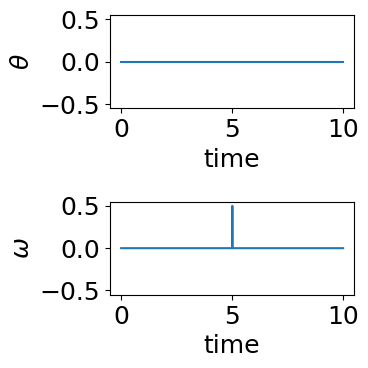

In [175]:
T = 10 # total duration
dt = 0.01 # discretisation step
n_plot = 100 # how many points to plot

A = np.array([[0, 1], 
              [-1, 0]]) # pendulum dynamics

n_plot = int(T//dt)
time = np.linspace(0,T,n_plot)

# initialize a sequence of inputs [time, state dimensions] with zeros
u = np.zeros((n_plot,2)) 

# Perturbation 1: add a single 'kick', a perturbation at time = 5 (out of 10)
u[500,1] = .5  # 2remove

# Perturbation 2: keep swinging the pendulum very fast (use sin/cos function)
# u[:,0] = 0.01 * np.cos(10*time) # 2remove

fig, ax = plt.subplots(2,1, figsize=(4,4))
R = np.max(np.abs(u))*1.1 # plotting range
for i,label in enumerate([''r"$\theta$",r"$\omega$"]):
    ax[i].plot(time,u[:,i])
    ax[i].set_xlabel('time')
    ax[i].set_ylabel(label)
    ax[i].set_ylim([-R,R])
plt.tight_layout()

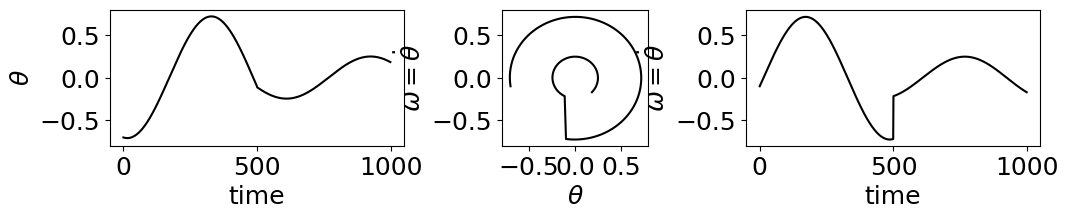

In [176]:
def numerical_2D_solution_with_input(x0,A,u,t,dt=0.01):
  ''' Integrates x' = Ax + u_t using a forward Euler scheme, given x(0) = x0;
  u = u_t is a vector of inputs
  Returns x(t) '''
  assert len(u) > t, 'Input sequence provided is not long enough' 
  assert len(u[0]) == 2, 'Input is not 2D'
  N = int(t//dt) 
  xn = x0 # current value of x_n
  for n in range(N):
    x_n_plus_1 = xn + (A @ xn)*dt + u[n]*dt # add input #2remove
    xn = x_n_plus_1  
  return xn

def plot_perturbed_oscillations(u, phi0 = -0.7, omega0 = -0.1, dt = dt):
  '''
  This function takes a sequence of inputs into dynamical system
  and plots the 2D trajectory for a perturbed oscillator
  '''
  x0 = np.array([phi0, omega0])
  fig, axes = plt.subplots(1,3,figsize=(12,2),gridspec_kw={'width_ratios': [2, 1, 2]})
  time = np.linspace(0,T,n_plot)
  numerical_traj = np.array([numerical_2D_solution_with_input(x0,A,u,t,dt=dt) for t in time])
  
  axes[1].plot(*numerical_traj.T,c='k')
  axes[1].set_xlabel(r"$\theta$")
  axes[1].set_ylabel(r"$\omega = \dot\theta$")
  R = np.max(np.abs(numerical_traj))*1.1
  axes[1].set_xlim([-R,R])
  for ax in axes:
    ax.set_ylim([-R,R])

  axes[0].plot(numerical_traj[:,0],c='k')
  axes[0].set_xlabel(r"time")
  axes[0].set_ylabel(r"$\theta$")

  axes[2].plot(numerical_traj[:,1],c='k')
  axes[2].set_xlabel(r"time")
  axes[2].set_ylabel(r"$\omega = \dot\theta$")
  # axes[2].legend(loc=(1.2,0))

  plt.subplots_adjust(left=None, bottom=.2, right=None, top=None, wspace=0.4, hspace=0.)

plot_perturbed_oscillations(u, dt=dt)

As we see, external input can change the state of the system in addition to the system's dynamics. 

This is how dynamical systems receive information from outside! E.g. we can model a brain area as a dynamical system, and input into this area from senses and other brain areas would be described as input $\mathbf{u}$.

Let us next discuss two major approaches to modelling populations of neurons as dynamical systems.

## Modeling neural populations: Network dynamics vs. latent dynamics

There are two ways to model the dynamics of a neural network: either by modelling the direct interactions between individual neurons, or by summarizing the dynamic modes in neural population activity in a *latent dynamics model* (latent meaning hidden, unobserved) [5].

![Fully observed models vs. models of latent dynamics](figures/Population_dynamics.jpeg)

In a latent dynamics model, a latent state $\mathbf{z}$ evolves in time:
$$\mathbf{\dot z} = A \mathbf{z} \tag{5}$$
and neural log-firing rates $\mathbf{y}(t)$ is a linear combination of the latent time-dependent variables $z_1(t), ..., z_n(t)$, which are often also called *factors*:
$$\log \mathbf{y}(t) = C \mathbf{z}(t) \tag{6}$$
(log firing rates can be negative or positive, while the firing rate is strictly non-negative due to exponentiation)

And the observed spike counts can be assumed to be Poisson distributed:
$$\mathbf{s}(t) \sim \mathrm{Poisson}(\mathbf{y}(t)) \tag{7}$$

The above model (6-7) is called in *observation* model, since it connects latent dynamics to observed neural spiking activity $\mathbf{s}(t)$. 
The latent dynamics model is a simplification of the full network dynamics, but it can still capture the main dynamic modes of the network.
Typically, the number of dimensions in the latent space $\mathrm{dim}~\mathbf{z}$ is much smaller than the number of neurons in the network $N$. Therefore, latent dynamics models also belong to the class of *dimensionality reduction* methods.

Suppose a network of $N=25$ neurons was following rotational dynamics, which, as we know, can be described by a 2D latent dynamics model:

In [177]:
A = np.array([[0, 1], 
              [-1, 0]]) # pendulum dynamics

Let us then assume that movements left/right start from the following initial conditions:
$$\mathrm{IC}_{left} \propto \mathcal{N} \left ( \begin{bmatrix}
-1 \\
0
\end{bmatrix} , \varepsilon I\right )$$

$$\mathrm{IC}_{right} \propto \mathcal{N} \left ( \begin{bmatrix}
+1 \\
0
\end{bmatrix} , \varepsilon I\right )$$

where $\varepsilon$ is a small number (jitter), and $\mathcal{N}(\mu, \Sigma)$ is a multivariate Gaussian distribution with mean $\mu$ and covariance $\Sigma$. So, there is a bit of a jitter about the initial conditions from trial to trial.

Text(0, 0.5, 'factor 2')

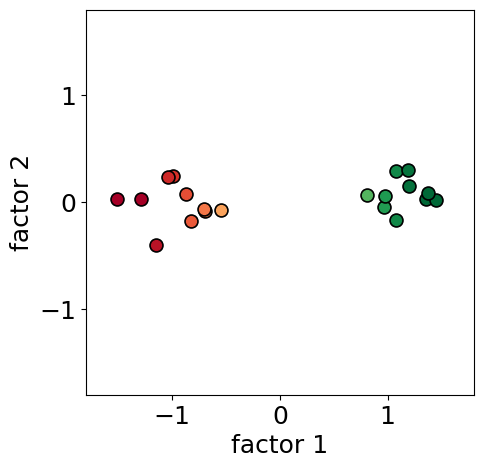

In [178]:
np.random.seed(0)
n = 10 # number of initial conditions (each, left and right)
jit_x, jit_y = .2, .2
jit = np.array([[jit_x,jit_y]]).T # amplitude of jitter in initial conditions
ICs_left = np.array([[1,0]]).repeat(n,axis=0).T + jit * np.random.randn(2,n)
ICs_right = np.array([[-1,0]]).repeat(n,axis=0).T + jit * np.random.randn(2,n)
z0 = np.concatenate([ICs_left,ICs_right],axis=1)

plt.figure(figsize=(5,5))
for z_i in z0.T:
    c = cmap((z_i[0]/2.5 + 0.5))
    plt.scatter(*z_i.T,marker='o',color='k',s=90)
    plt.scatter(*z_i.T,marker='o',color=c,s=50)

plt.xlim(-1.8,1.8)
plt.ylim(-1.8,1.8)
plt.xlabel('factor 1')
plt.ylabel('factor 2')

Now let us finally solve the latent dynamics model (5) numerically. We will use a function for analytical solution of a dynamical system from Exercise 3:

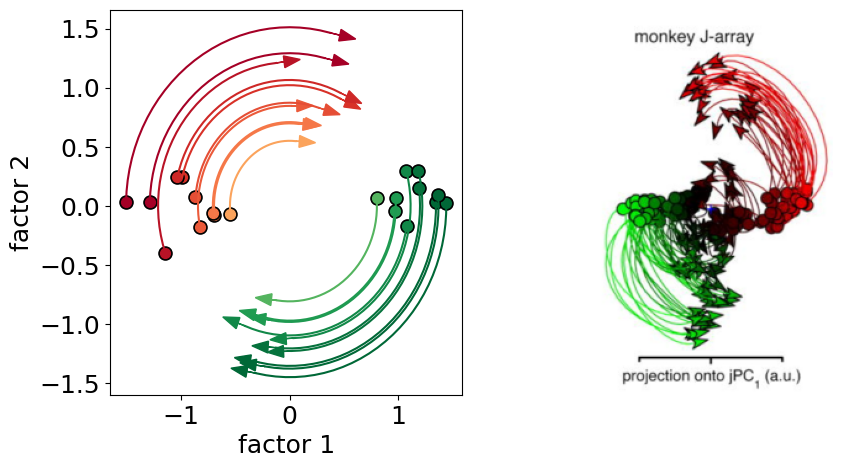

In [179]:
z = np.array([analytical_2D_solution(z0,A,t) for t in np.linspace(0,1.8,30)]) # time x latent_dims x trials
z = np.einsum('ijk->kij',z) # trials x time x latent_dims
fig, ax = plt.subplots(1,2,figsize=(10,5))
for z_i in z:
    c = cmap((z_i[0,0]/2.5 + 0.5))
    ax[0].plot(*z_i.T,c=c)
    ax[0].arrow(*z_i[-1],*(z_i[-1]-z_i[-2]),color=c,head_width=.1)
    ax[0].scatter(*z_i[0].T,marker='o',color='k',s=90)
    ax[0].scatter(*z_i[0].T,marker='o',color=c,s=50)

ax[0].set_xlabel('factor 1')
ax[0].set_ylabel('factor 2')

# insert image in ax[1]
ax[1].imshow(plt.imread('figures/Rotational_dynamics.png'))
ax[1].axis('off');

It looks like a twin sister of Figure 3 from the latent neural population dynamics discovered in the *Churchland et al. 2012* [3] paper!

Let us now use this dynamics to generate some neural activity.

### Exercise 7. Generate spike trains from a latent dynamics model

In [180]:
N = 25 # number of neurons
np.random.seed(0)
C = np.random.randn(N,2)*0.8 # neurons x latent_dims

Given the latent factors $\mathbf{z}(t)$ (in a shape of *[trials, time, latent_dims]*) and the matrix $C$, generate firing rates $\mathbf{y}(t)$ (in a shape of *[trials, time, neurons]*):

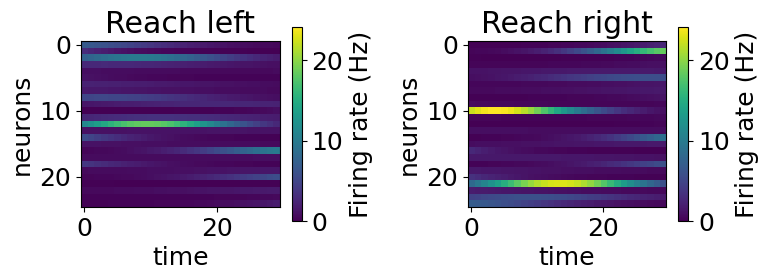

In [181]:
y = np.exp(z @ C.T) # 2remove 

fig, ax = plt.subplots(1,2,figsize=(8,3))
fr_max = y.max()
im = ax[0].imshow(y[0].T,vmin=0,vmax=fr_max)
ax[1].imshow(y[n].T,vmin=0,vmax=fr_max)
ax[0].set_title('Reach left')
ax[1].set_title('Reach right')
for a in ax:
    a.set_ylabel('neurons')
    a.set_xlabel('time')
    plt.colorbar(im, ax=a, label='Firing rate (Hz)')
plt.tight_layout()

We can see that now different neurons are active at the movement initiation (t=0) compared to the movement termination (later time). This challenges the classical 'representational' paradigm where movement would be responsible for moving left or moving right and supposed to be active throughout the whole trial.

Now using these firing rates and `np.random.poisson()` function, let us generate spike trains:

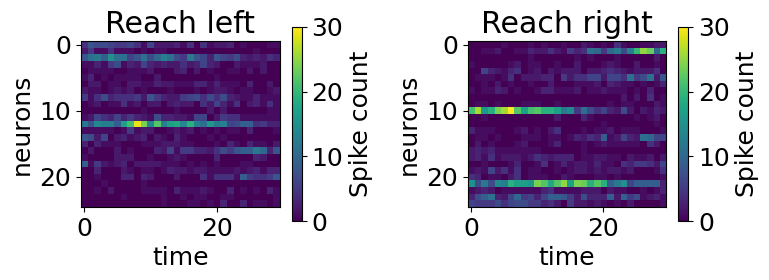

In [182]:
s = np.random.poisson(y) # 2remove  

fig, ax = plt.subplots(1,2,figsize=(8,3))
count_max = s.max()
im = ax[0].imshow(s[0].T,vmin=0,vmax=count_max)
ax[1].imshow(s[n].T,vmin=0,vmax=count_max)
ax[0].set_title('Reach left')
ax[1].set_title('Reach right')
for a in ax:
    a.set_ylabel('neurons')
    a.set_xlabel('time')
    plt.colorbar(im, ax=a, label='Spike count')
plt.tight_layout()


Inverting a latent dynamics model is a difficult problem called *inference*. Depending on the latent dynamics (linear or nonlinear) and the observation model, the inference can either be analytically tractable (i.e. we can write down an analytical solution) or would require approximate inference methods, which are advanced Machine Learning topics. This can get very technically involved.

Yet, understanding the *generative model* (i.e. how the data is generated, or eq. (5)-(7)) is a crucial step in understanding the latent dynamics models and reading a large plast of computational neuroscience papers.

## Summary

In the first part of this tutorial, we learned:

1. What linear systems can and can not do
2. What fixed points are and how to check their stability
3. How to read eigenspectra
4. How to incorporate external input
5. How latent neural dynamics relates to observed spiking activity


# Part 2: Nonlinear dynamical systems

### Dimensionality reduction on Hodgkin-Huxley model

To recap, the set of Hodgkin-Huxley (HH) equations contained the following 4 equations:

$$C \frac{dV}{dt} = -\bar g_K n^4 (V - V_K) - \bar g_{Na} m^3 h(V-V_{Na}) - \bar g_l (V - V_l) + I_{ext}\tag{4a}$$

$$\frac{dn}{dt} = \alpha_n(V)(1-n) - \beta_n(V) n\tag{4b}$$
$$\frac{dm}{dt} = \alpha_m(V)(1-m) - \beta_m(V) m\tag{4c}$$
$$\frac{dh}{dt} = \alpha_h(V)(1-h) - \beta_h(V) h\tag{4d}$$

The state space of this model is 4D, which is too much for visualization and analyse.
However, not all equations here are equally important. 

![Gate timescales](figures/hh_gates.jpg) 

**Fig. 1a**  The equilibrium functions for the three variables m,n,h | **Fig. 1b** The voltage dependent time constants

#### Step 1. Time scale separation between fast ($V$) and very-fast ($m$) variables

  First, we can look at the timescales of different equations (Fig. 1a).  We see that sodium channel activation $m$ changes much faster than other gating variables, faster than a single spike ($<$1ms).
Therefore, we can assume that equation (4c) always quickly reaches equilibrium $dm/dt=0$, and substitute eq. (4c) with a *quasi-steady state* approximation $m(t) = m_0(V(t))$. Thus, we get rid of a differential equation (4c).

#### Step 2. Merging two similar slow equations ($n$ and $h$)

  From Fig.1a we also see that both sodium channel inactivation $h$ and potassium channel gating $n$ change slowly (on a scale of 5-10ms). We can also notice that in Fig.1b $n(V)$ looks roughly like $1-h(V)$ (not exactly, but it is an approximation).
So, since these two variables have similar dependencies on both time and voltage, we can substitute them with a single variable $w$ that approximates both gating variables. Thus, we merge eq. (4b) and (4d) into one. 

#### Result: 2D FitzHugh-Nagumo (FHN) model

Following 2 steps above, we merged 2 **fast** equations and 2 **slow** equations, which results in the following model (see [6] if interested in a rigorous derivation):

\begin{align}
\mathrm{\mathbf{Fast:}} \quad\frac{dV}{dt} &= V(1-V)(V-V_{thr}) - w + i_{ext} \tag{5a}\\
\mathrm{\mathbf{Slow:}} ~\quad \frac{dw}{dt} &= \epsilon (\beta V - w) \tag{5b}
\end{align}

here some coefficients like time constants and capacitance of the membrane are typically omitted for simplicity.

The two equations are also often called **fast activator** and **slow inhibitor**. Because the first equation describes cell's depolarization and sodium channel opening (activation), while the second equation describes everything that works towards repolarization (potassium currents + sodium channels' inactivation).
The parameter responsible for fast/slow timescales separation is $\epsilon$, which is typically set to $0.01$ (i.e. 5b is 100x slower than 5a).

Now that we have a 2D system, we can visualize its phase portrait!

### Phase portrait of FHN

#### **Exercise 8**: Code up FHN equations

In [183]:
# Plotting phase portraits
def plot_FHN_phase_portrait(i_ext,V_thr,beta,
                            V_null = None, w_null = None,
                            V_min = -.5, V_max = 1.2,
                            w_min = -.1, w_max = .2,
                            eps=0.01,n=30):
  '''
    Plots a phase portrait for a FitzHugh-Nagumo model (eq. 5)
    n: number of points in the n x n grid
  '''
  plt.figure(figsize=(5,5))
  V_grid = np.linspace(V_min,V_max, n) # a 1D activator grid
  w_grid = np.linspace(w_min,w_max, n) # a 1D inhibitor grid
  x = np.array(np.meshgrid(V_grid, w_grid)).reshape((2,-1)) # a 2D flattened grid
  V, w = x
  V_dot = V*(1-V)*(V-V_thr) - w + i_ext #2remove
  w_dot = eps*(beta * V - w) #2remove
  plt.streamplot(V_grid,w_grid,V_dot.reshape(n,n),w_dot.reshape(n,n),
                 color=np.linalg.norm(np.array([V_dot,w_dot]),axis=0).reshape(n,n),
                 cmap='coolwarm',density=1.5)
  if V_null is not None:
    plt.plot(V_grid,V_null(V_grid,V_thr,i_ext),c='k')
  if w_null is not None:
    plt.plot(V_grid,w_null(V_grid,beta),c='k')
  plt.xlabel('fast activator V')
  plt.ylabel('slow inhibitor w')
  plt.xlim([V_min,V_max])
  plt.ylim([w_min,w_max])
  plt.clim(vmin=0,vmax=.2)

@widgets.interact
def interactive_FHN_portrait(i_ext=widgets.FloatSlider(min=-.2, max=.3, value=0), 
                            V_thr=widgets.FloatSlider(min=0, max=1, value=0.2),
                            beta=widgets.FloatSlider(min=0.05, max=.5, value=.4),):
  plot_FHN_phase_portrait(i_ext,V_thr,beta)

interactive(children=(FloatSlider(value=0.0, description='i_ext', max=0.3, min=-0.2), FloatSlider(value=0.2, d…

Looks very complicated! Although, if we look at some parts of the phase plane, locally it might resemble some of the patterns of an LDS behavior that we have seen before. (by the way, which ones?)

### Fixed points, nullclines, stability

While linear systems had just one fixed point, non-linear systems can have many. Moreover, even the number of fixed points can change depending on the parameters (like $V_{thr}$ or $\gamma$) 🤯

We can find fixed points, by dealing with equations (5a) and (5b) one by one. The set of points where $\dot V = 0$ is called **$V$-nullcline**. Nullclines divide the phase plane into two parts, based on the sign on the derivative. 

#### Exercise 9: FHN nullclines and fixed points
Let us add the nullclines to the phase portrait. We will define them as functions + learn an additional way to define single-expression functions in python: 

In [184]:
V_nullcline = None
w_nullcline = None
@widgets.interact
def interactive_FHN_portrait(i_ext=widgets.FloatSlider(min=-.2, max=.3, value=0,step=.01), 
                            V_thr=widgets.FloatSlider(min=0, max=1, value=0.2),
                            beta=widgets.FloatSlider(min=0.05, max=.5, value=.4, step=0.01),):

  global V_nullcline, w_nullcline

  # There are two ways to define functions in python.
  # 1. def name(args): (function)
  #       ... some computations
  #       return output
  # 2. name = lambda args: output (a lambda-function: 1) has one expression for outputs; 2) does not have to have a name)

  # write equations for nullclines as a function of V: lambda-way
  V_nullcline = lambda V, V_thr, i_ext: V*(1-V)*(V-V_thr)+i_ext   #2remove
  w_nullcline = lambda V, beta: V*beta                            #2remove

  # write equations for nullclines as a function of V: standard-way
  def V_nullcline(V, V_thr, i_ext):
    return V*(1-V)*(V-V_thr)+i_ext   #2remove
  def w_nullcline(V, beta):
    return V*beta                            #2remove

  plot_FHN_phase_portrait(i_ext,V_thr,beta,
                          V_null = V_nullcline, w_null = w_nullcline)

interactive(children=(FloatSlider(value=0.0, description='i_ext', max=0.3, min=-0.2, step=0.01), FloatSlider(v…

#### Think!
What is the minimal and maximal number of fixed points we can get?

**Solution:** minimal 1, maximal 3

### Analysing stability


#### Local stability


Suppose the nullclines are intersecting somewhere in the middle, like this:

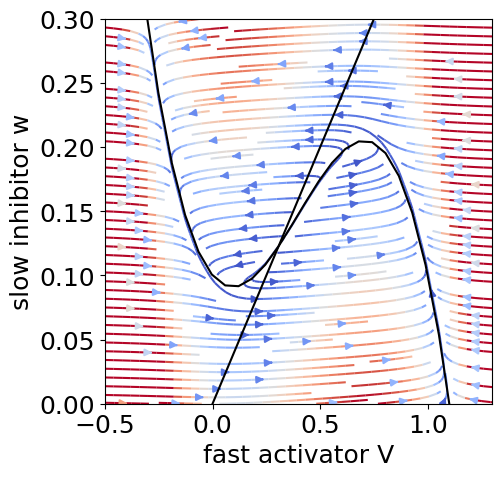

In [185]:
i_ext, V_thr, beta = 0.1, 0.2, 0.4
plot_FHN_phase_portrait(i_ext,V_thr,beta,
                        V_max=1.3, w_min=0, w_max=.3,
                        V_null = V_nullcline, w_null = w_nullcline)

We see that globally, in the whole phase plane, the arrows that indicate the derivative $\mathbf{\dot x} = [\dot V, \dot w]^T$ change their directions in non-trivial ways, because $\mathbf{\dot x} = F(\mathbf{x})$ is non-linear. 

However, we can locally **linearize** the dynamical system:  approximate the the evolution operator $F(.)$ with a linear function:

$$\mathbf{\dot x} = F(\mathbf{x}) \approx \left.\frac{\partial \mathbf{F}}{\partial \mathbf{x}}\right |_{x_0} \mathbf{x} + \mathbf{b} = 
\begin{bmatrix}
    \frac{\partial F_V}{\partial V} & \frac{\partial F_V}{\partial w}\\
    \frac{\partial F_w}{\partial V} & \frac{\partial F_w}{\partial w}
\end{bmatrix}_{\mathbf{x}_0}  \mathbf{x} + \mathbf{b}$$

If we linearize about a randomly picked point on the phase plane, we'll get an additional non-zero term $\mathbf{b}$.

But if $x_0$ is a fixed point, then:

$$\mathbf{\dot x} = \mathbf{\dot{(x - x_0)}} = 
\begin{bmatrix}
    \frac{\partial F_V}{\partial V} & \frac{\partial F_V}{\partial w}\\
    \frac{\partial F_w}{\partial V} & \frac{\partial F_w}{\partial w}
\end{bmatrix}_{\mathbf{x}_0}  (\mathbf{x} -\mathbf{x_0})$$

because for $\mathbf{x} =\mathbf{x_0}$ the derivative must be zero. This can be rewritten simply as:
$$\mathbf{\dot{\hat x}}= \mathrm{J} \mathbf{\hat x}$$

This matrix $\mathrm{J}$ is called a **Jacobian** (scary name!). But it only has 4 components, which we can derive analytically (with pen and paper) from eq. 5a-5b:

#### **Exercise 10:** Calculating the Jacobian

In [186]:
def find_nullcline_intersection(V_thr,i_ext,beta):
  diff = lambda x: np.abs(V_nullcline(x,V_thr,i_ext) - w_nullcline(x,beta))
  return minimize(diff,0.4).x[0]


eps = 0.01
V = find_nullcline_intersection(V_thr,i_ext,beta)
print(f'Nullclines intersect at V={V:.3f}')
J = np.array([[(1-V)*(V-V_thr)+i_ext, -1],
              [eps*beta, -eps]])               #2remove

print("Eigenvalues of a Jacobian: ",np.linalg.eig(J)[0])

Nullclines intersect at V=0.307
Eigenvalues of a Jacobian:  [0.14882255 0.01518534]


##### **Think!**
So, is it stable? (for these hyperparameters)

**Answer:** No. The eigenvalues are positive, so the solution is repulsed from the fixed point.

#### Global stability

Now let us take a step back. **Literally.** Let us zoom out on that phase portrait:

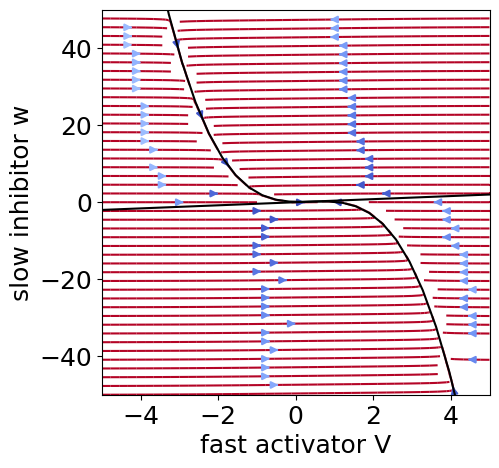

In [187]:
i_ext, V_thr, beta = 0.1, 0.2, 0.4
plot_FHN_phase_portrait(i_ext,V_thr,beta, eps=.1,
                        V_min=-5, V_max=5, w_min=-50, w_max=50,
                        V_null = V_nullcline, w_null = w_nullcline)

##### **Think!**
We see that all of the arrows are point towards the cubic V-nullcline. But why are they horizontal? *(click for answer)*


**Answer:** Because of timescale separation, eps << 1. The rate of change of the state is much higher in horizontal direction than in vertical. After they reach the cubic V-nulcline, V does not change anymore, but $ dw/dt \sim -w$ for large $w$. So, overall, the system is attracted towards (0,0) on a global scale.

#### **Summarize and Think!**

What should happen on intermediate timescale if:
1. **locally**: two nullclines have only one intersection which is a *repeller*
2. **globally** the states are *attracted* towards (0,0)

?


**Answer:** Since there are no other stable fixed points, the state can not stop changing. It is repelled both from the unstable fixed point and from the infinity... so it must then orbit around the unstable point! 🪐

**Time for blackboard exercise in nullclines, signs of the derivatives and stability!**

### **Exercise 11:** Visualizing trajectories

With all the knowledge you possess now, you can figure out all possible behaviors of this system with only pen and paper. Let us confirm our analysis and visulize some trajectories starting from random initial conditions:

In [188]:
def plot_FHN_trajectories(i_ext,V_thr,beta,
                          N=10, T=20000, dt=.1,eps=0.01,n=30):
  '''
    Plots trajectories for a FitzHugh-Nagumo model (eq. 5)
  '''
  fig, ax = plt.subplots(1,2,figsize=(15,5),gridspec_kw={'width_ratios': [1,2]})

  # plot trajectories
  V_dot = lambda V, w: V*(1-V)*(V-V_thr) - w + i_ext
  w_dot = lambda V, w: eps*(beta * V - w)
  # generate some initial conditions
  V_0 = np.random.randn(N) * .5 + 0.5
  w_0 = np.random.randn(N) * .02 + .05
  # create an empty array for storing solutions 
  traject = np.empty((2,T+1,N))
  traject[:,0] = np.array([V_0, w_0])
  for t in range(T):
    traject[:,t+1] = np.clip(
                      [traject[0,t] + V_dot(*traject[:,t])*dt,
                      traject[1,t] + w_dot(*traject[:,t])*dt],-10,10)
  for i in range(N):
    ax[0].plot(*traject[...,i],alpha=.3,linewidth=5)
    ax[1].plot(traject[0,:,i])

  # plot nullclines
  global V_nullcline, w_nullcline
  V_grid = np.linspace(-.5, 1.2, n) # a 1D activator grid
  ax[0].plot(V_grid,V_nullcline(V_grid,V_thr,i_ext),c='k')
  ax[0].plot(V_grid,w_nullcline(V_grid,beta),c='k')
  
  ax[0].set_xlabel('fast activator V')
  ax[0].set_ylabel('slow inhibitor w')
  ax[1].set_ylabel('fast activator V')
  ax[1].set_xlabel('time')
  ax[0].set_xlim([-.5,1.2])
  ax[1].set_ylim([-.5,1.2])
  ax[0].set_ylim([-.1,.2])

@widgets.interact
def interactive_FHN_trajectories(i_ext=widgets.FloatSlider(min=-.2, max=.3, value=0,step=.01), 
                            V_thr=widgets.FloatSlider(min=0, max=1, value=0.2),
                            beta=widgets.FloatSlider(min=0.05, max=.5, value=.25, step=.01),):
  plot_FHN_trajectories(i_ext,V_thr,beta)

interactive(children=(FloatSlider(value=0.0, description='i_ext', max=0.3, min=-0.2, step=0.01), FloatSlider(v…

Yay, we've got action potentials!

Not particularly beautiful action potentials (well, it is an approximated, reduced model), but still action potentials!

If you don't see anything like action potentials, try stimulating the FHN neuron just a little bit with the external current $i_{ext}$. It makes sense, right? The neuron responds to some inputs.



### **Think: linear vs nonlinear oscillations**

Now that you've seen a linear oscillator and a non-linear oscillator (limit cycle), what is the key qualitative difference between them? How would the amplitude of oscillations change if you change initial conditions?

**Solution:** Non-linear oscillator has a roughly fixed amplitude regardless of the initial conditions, while the amplitude of linear oscillator linearly depends on initial conditions (in other words, the further you swing the pendulum, the larger the amplitude will be).

In biology, many things have fixed amplitudes. For instance, action potential stays within a certain limit of voltages (e.g. -80 to +20 mV). A limit cycle model explains this behavior. In neuroscience, limit cycles can be found in central pattern generator (CPT) literature.

## Summary

In the second part of the tutorial, we:
1. Learned that nonlinear systems can have not just *one* but *many* fixed points
2. Learned how to linearize the dynamical system about a fixed point and check its local stability
3. Learned a new type of an attractor: a limit cycle!
4. Simulated some action potentials!

# References

1. Izhikevich, Eugene M. [Dynamical systems in neuroscience.](https://www.izhikevich.org/publications/dsn.pdf) MIT press, 2007.

2. Gerstner, Wulfram, et al. [Neuronal dynamics](https://neuronaldynamics.epfl.ch/index.html): From single neurons to networks and models of cognition. Cambridge University Press, 2014.

3. Churchland, Mark M., et al. [Neural population dynamics during reaching.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3393826/) Nature 487.7405 (2012): 51-56.

<!-- ## Other great tutorials: -->
4. Linear dynamical systems by Bing Wen Brunton and Alice Schwarze [Neuromatch: W2D2](https://compneuro.neuromatch.io/tutorials/W2D2_LinearSystems/student/W2D2_Tutorial1.html), 2020-now

5. Hurwitz, Cole, et al. [Building population models for large-scale neural recordings: Opportunities and pitfalls.](https://pubmed.ncbi.nlm.nih.gov/34411907/) Current opinion in neurobiology 70 (2021): 64-73.

6. Rinzel, John. [Excitation dynamics: insights from simplified membrane models.](https://neurophysics.ucsd.edu/courses/physics_171/Rinzel_FedProc_85.pdf) Fed. proc. Vol. 44. No. 15. 1985.